In [1]:
import os 
import sys

import healpy as hp
import matplotlib.pyplot as plt
import numpy as np

import toast

In [2]:
import scipy.signal as si

In [3]:
import pysm3
import pysm3.units as usm

In [4]:
import skytools

In [5]:
import astropy.units as u 

In [6]:
env = toast.utils.Environment.get()
comm, procs, rank = toast.get_world()
nthread = os.environ["OMP_NUM_THREADS"]

In [7]:
#os.environ

In [8]:
mem = toast.utils.memreport(msg="(whole node)", comm=comm, silent=False)

Memory usage (whole node)
       total :  503.138 GB
   available :  392.253 GB
     percent :   22.000 % 
     percent :   22.100 %  (after GC)
        used :   91.778 GB
        free :  279.724 GB
      active :   16.486 GB
    inactive :  151.689 GB
     buffers :  206.457 MB
      cached :  131.434 GB
      shared :    3.284 GB
        slab :   27.126 GB



0. Read Planck map

In [9]:
NSIDE = 512
lmax = 2*NSIDE

In [10]:
amin2rad = np.pi/(60*180)

fwhm_spsat = 72.8*amin2rad

fwhm_planck = 35*amin2rad

fwhm_planck

bl_spsat = hp.gauss_beam(fwhm=fwhm_spsat,lmax=lmax,pol=True)
bl_planck = hp.gauss_beam(fwhm=fwhm_planck,lmax=lmax,pol=True)


In [11]:
rGC = hp.rotator.Rotator(coord=['G','C'])  # Transforms galactic to equatorial coordinates


In [12]:
truesky_GC512 = hp.read_map(filename='cmb_030_GC_nside.FITS',field=None)

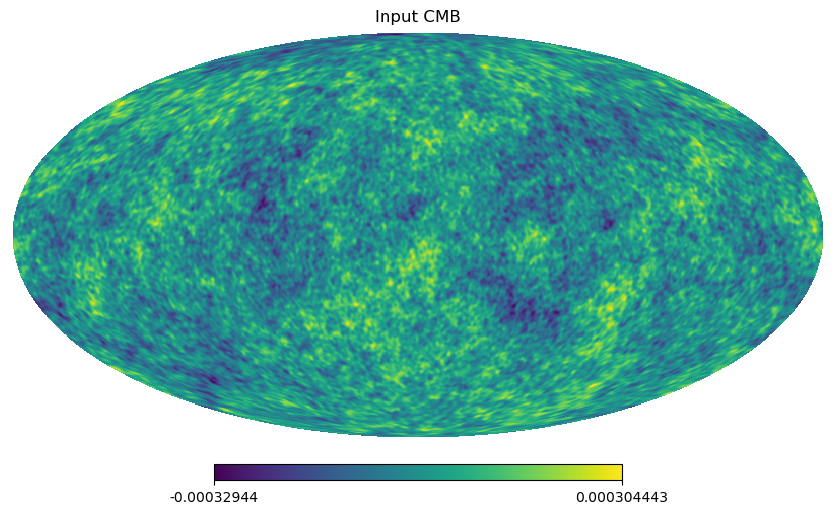

In [13]:
hp.mollview(truesky_GC512[0],title = 'Input CMB')

In [14]:
def D_ell(maps, lmax, use_pixel_weights=False):
    l_arr = np.arange(0,lmax+1)
    cl_s = hp.anafast(maps, lmax=lmax,use_pixel_weights=use_pixel_weights)
    return (cl_s[:]*l_arr*(l_arr+1)/(2*np.pi))

In [15]:
l_arr = np.arange(0,lmax+1)

Create a telescope and corresponding pointing

1. Start by creating a focalplane with a sample rate and number of detectors

In [16]:
from toast.qarray import to_iso_angles, rotation, mult, to_lonlat_angles
xrot = rotation([0,1,0], np.pi/2)


In [17]:
from toast.instrument_sim import fake_hexagon_focalplane, plot_focalplane

In [18]:
focalplane = toast.instrument.Focalplane(sample_rate=10*u.Hz#,thinfp=256
                                        )
##One fourth of total detectors in the focalplane
## For S4, sample rate ~10-100

In [19]:
with toast.io.H5File("focalplane_SAT3_SAT_f030.h5", "r", comm=comm, force_serial=True) as f:
            focalplane.load_hdf5(f.handle, comm=comm)

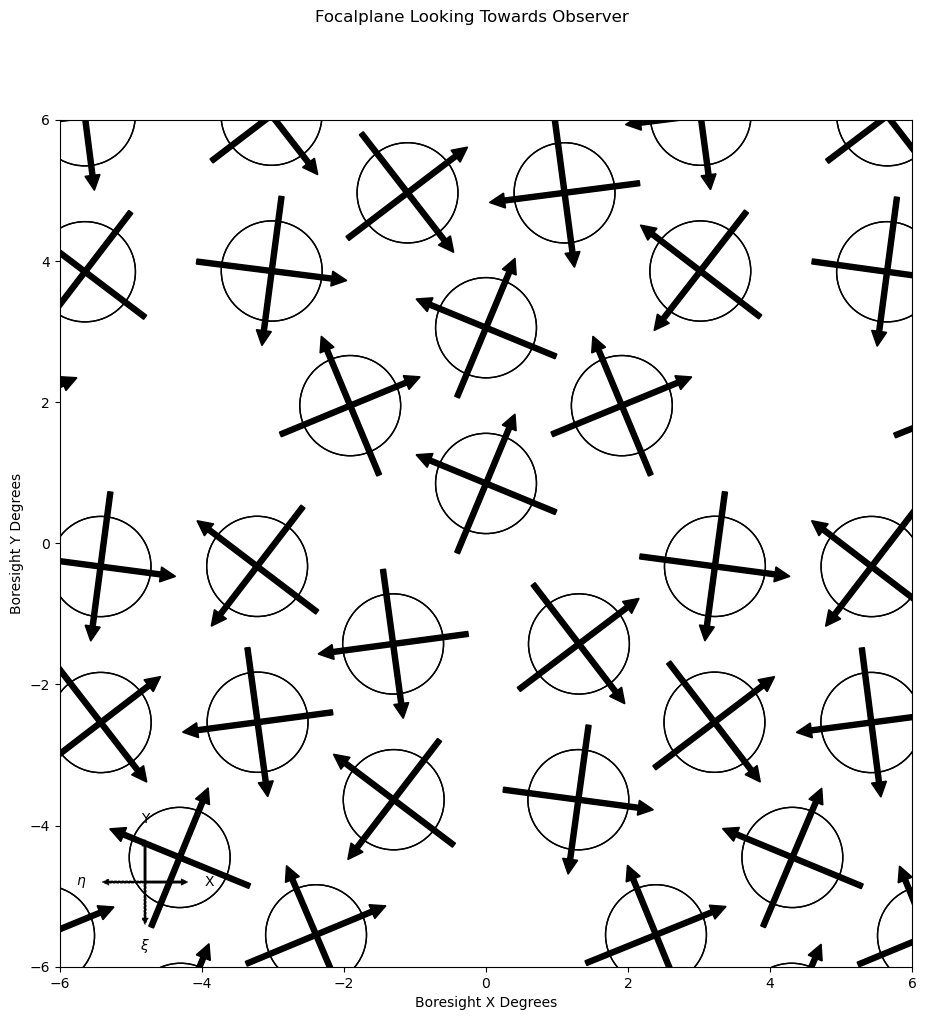

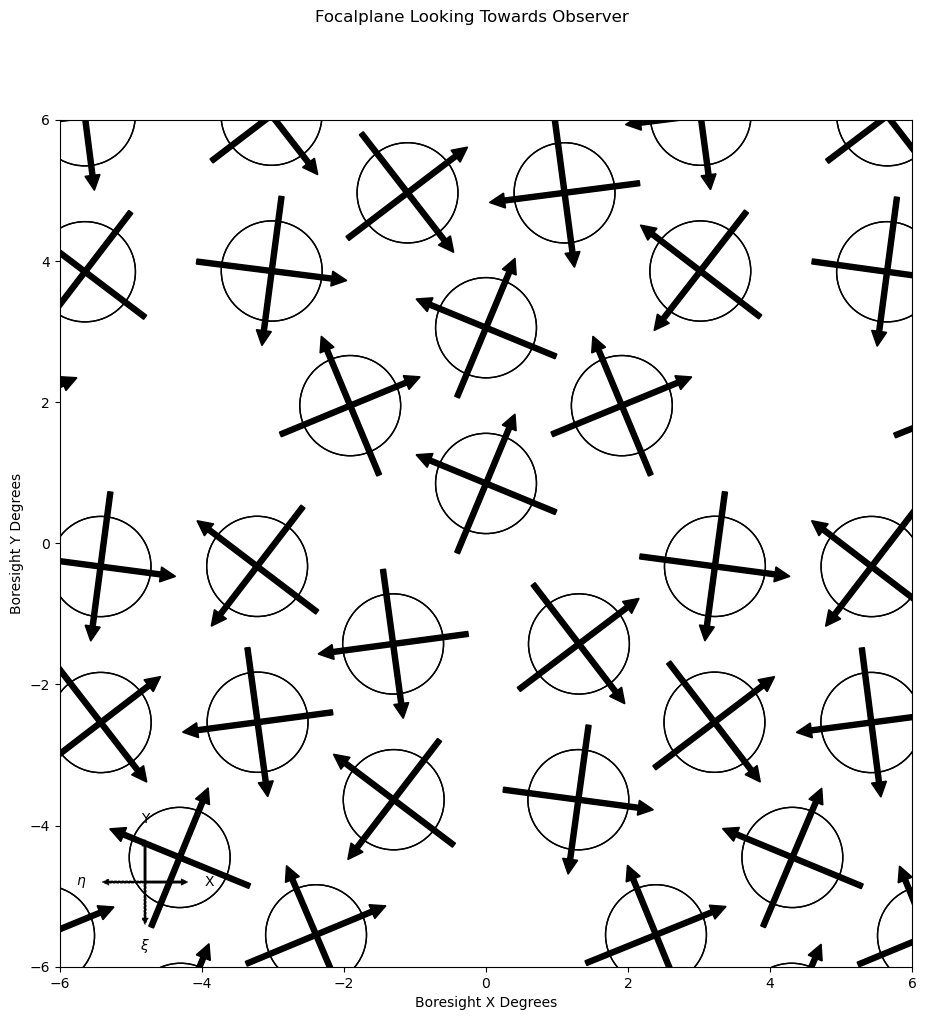

In [20]:
plot_focalplane(focalplane, width=10*u.degree, height = 10*u.degree)

In [21]:
len(focalplane.detectors)

252

Print focalplane information

In [22]:
for detec in focalplane.detectors:
    q = focalplane[detec]["quat"]
    print(np.degrees(to_lonlat_angles(mult(xrot,q))))

[ 1.94993571  1.91117068 22.5       ]
[  1.94993571   1.91117068 112.5       ]
[3.05321419e+00 1.27222187e-14 6.75000000e+01]
[3.05321419e+00 1.27222187e-14 1.57500000e+02]
[ 0.84665724  0.         67.5       ]
[  0.84665724   0.         157.5       ]
[ 1.94993571 -1.91117068 22.5       ]
[  1.94993571  -1.91117068 112.5       ]
[  7.17209843   1.10213313 -97.5670297 ]
[ 7.17209843  1.10213313 -7.5670297 ]
[  4.96503074   1.10371952 -52.50613882]
[ 4.96503074  1.10371952 37.49386118]
[  6.06983805   3.0142125  -52.54583908]
[ 6.06983805  3.0142125  37.45416092]
[  3.86012121   3.01427169 -97.44803143]
[ 3.86012121  3.01427169 -7.44803143]
[  3.86012121  -3.01427169 142.44803143]
[   3.86012121   -3.01427169 -127.55196857]
[   4.96503074   -1.10371952 -172.49386118]
[  4.96503074  -1.10371952 -82.49386118]
[   6.06983805   -3.0142125  -172.45416092]
[  6.06983805  -3.0142125  -82.45416092]
[  7.17209843  -1.10213313 142.5670297 ]
[   7.17209843   -1.10213313 -127.4329703 ]
[-5.58231042 

In [23]:
lonlat_angles = np.array([np.degrees(to_lonlat_angles(mult(xrot,focalplane[detec]["quat"])))for detec in focalplane.detectors])

In [24]:
lonlat_angles.shape

(252, 3)

In [25]:
np.where(np.abs(lonlat_angles[:,0]-lonlat_angles[0,0])<1e-4)

(array([0, 1, 6, 7]),)

In [26]:
focalplane._det_to_row

{'029_000_SAT_f030_A': 0,
 '029_000_SAT_f030_B': 1,
 '029_001_SAT_f030_A': 2,
 '029_001_SAT_f030_B': 3,
 '029_002_SAT_f030_A': 4,
 '029_002_SAT_f030_B': 5,
 '029_003_SAT_f030_A': 6,
 '029_003_SAT_f030_B': 7,
 '029_004_SAT_f030_A': 8,
 '029_004_SAT_f030_B': 9,
 '029_005_SAT_f030_A': 10,
 '029_005_SAT_f030_B': 11,
 '029_006_SAT_f030_A': 12,
 '029_006_SAT_f030_B': 13,
 '029_007_SAT_f030_A': 14,
 '029_007_SAT_f030_B': 15,
 '029_008_SAT_f030_A': 16,
 '029_008_SAT_f030_B': 17,
 '029_009_SAT_f030_A': 18,
 '029_009_SAT_f030_B': 19,
 '029_010_SAT_f030_A': 20,
 '029_010_SAT_f030_B': 21,
 '029_011_SAT_f030_A': 22,
 '029_011_SAT_f030_B': 23,
 '030_000_SAT_f030_A': 24,
 '030_000_SAT_f030_B': 25,
 '030_001_SAT_f030_A': 26,
 '030_001_SAT_f030_B': 27,
 '030_002_SAT_f030_A': 28,
 '030_002_SAT_f030_B': 29,
 '030_003_SAT_f030_A': 30,
 '030_003_SAT_f030_B': 31,
 '030_004_SAT_f030_A': 32,
 '030_004_SAT_f030_B': 33,
 '030_005_SAT_f030_A': 34,
 '030_005_SAT_f030_B': 35,
 '030_006_SAT_f030_A': 36,
 '030_006_S

In [27]:
q1 = focalplane['029_000_SAT_f030_A']["quat"]
q2 = focalplane['029_003_SAT_f030_A']["quat"]
print(np.degrees(to_lonlat_angles(mult(xrot,q1))))
print(np.degrees(to_lonlat_angles(mult(xrot,q2))))


[ 1.94993571  1.91117068 22.5       ]
[ 1.94993571 -1.91117068 22.5       ]


Define the schedule, site and telescope

In [28]:
print(focalplane._det_to_row['029_000_SAT_f030_A'])
print(focalplane._det_to_row['029_003_SAT_f030_A'])


0
6


In [29]:
focalplane._det_to_row = {'029_000_SAT_f030_A': 0,
  '029_003_SAT_f030_A': 6}
#=focalplane._det_to_row[:4]

In [30]:
focalplane._det_to_row

{'029_000_SAT_f030_A': 0, '029_003_SAT_f030_A': 6}

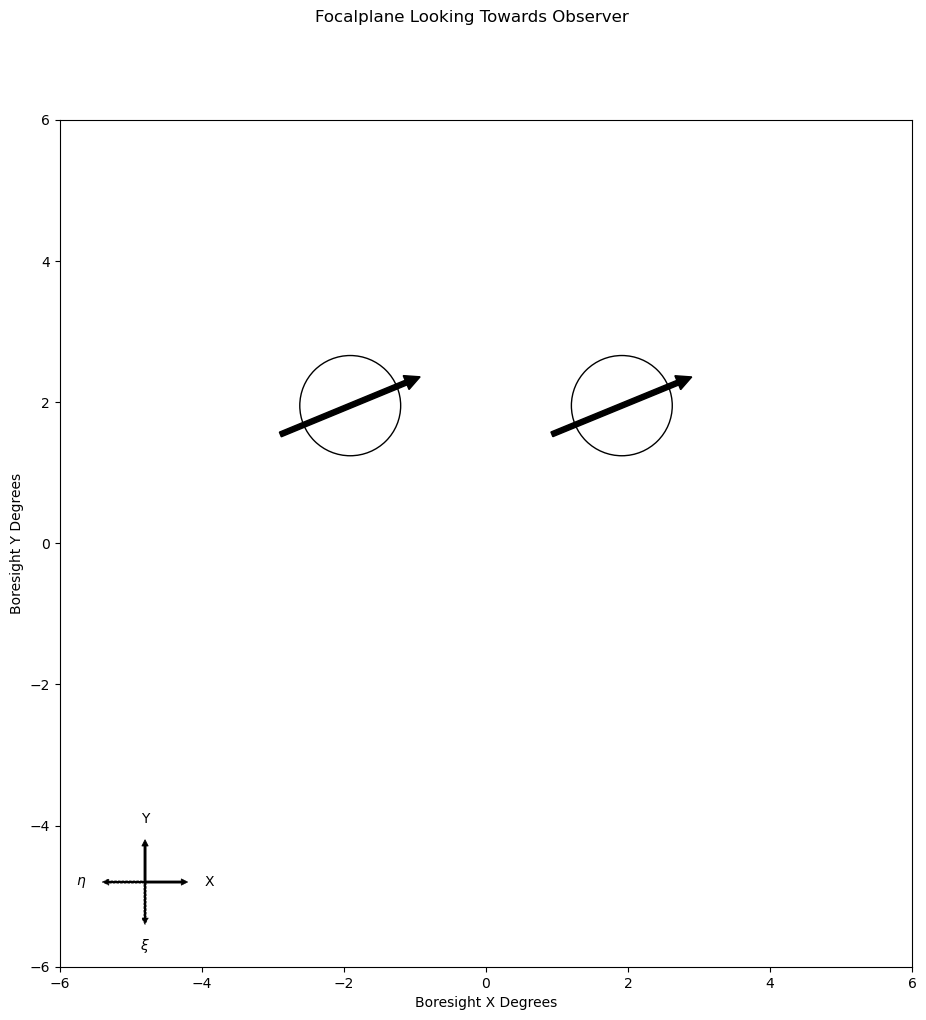

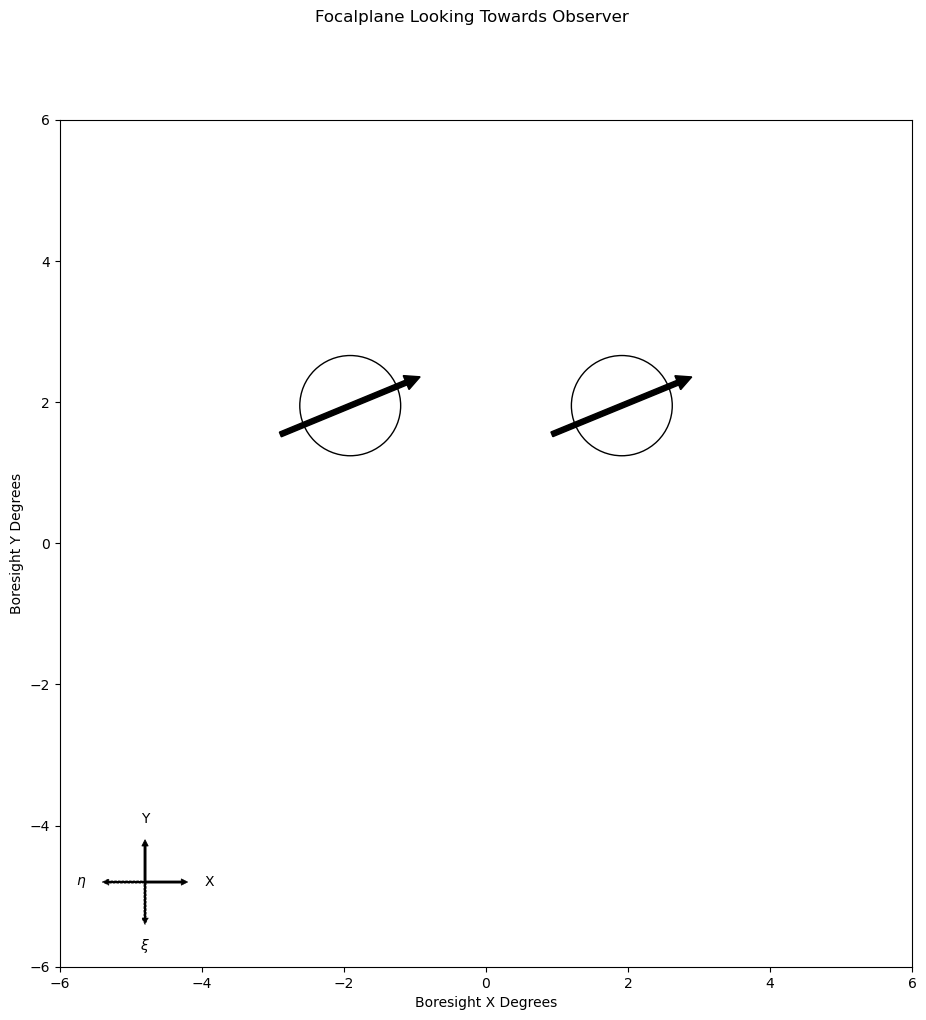

In [31]:
plot_focalplane(focalplane, width=10*u.degree, height = 10*u.degree)

In [32]:
focalplane

<Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 029_003_SAT_f030_A]>

In [33]:
focalplane

<Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 029_003_SAT_f030_A]>

In [34]:
schedule = toast.schedule.GroundSchedule()
#for i in range(7):
#    schedule.read("POLE_DEEP-169-"+str(i+1)+".txt", comm=comm)
schedule.read("POLE_DEEP-169-1.txt", comm=comm)

TOAST INFO: Loading schedule from POLE_DEEP-169-1.txt
TOAST INFO: Loaded 1 scans from POLE_DEEP-169-1.txt totaling 84.0 minutes.


Print schedule information

In [35]:
schedule

<GroundSchedule site=SOUTH_POLE at -89.991 deg, -44.65 deg, 2843.0 m telescope SAT with 1 scans
  <GroundScan 'POLE_DEEP' at 2027-05-28T06:00:00+00:00 with El = 52.6 deg, Az 63.59 deg -- 134.26 deg>
>

Print telescope information

In [36]:
site = toast.instrument.GroundSite(
        schedule.site_name,
        schedule.site_lat,
        schedule.site_lon,
        schedule.site_alt,
        weather=None,
    )
telescope = toast.instrument.Telescope(
        "My_telescope", focalplane=focalplane, site=site
    )

In [37]:
telescope

<Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = None>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 029_003_SAT_f030_A]>>

We can have multiple groups for parallel computing (start with one). Create a Data Instance and simulate a ground observation operator.

In [38]:
toast_comm = toast.Comm(world=comm, groupsize=1)

In [39]:
data = toast.Data(comm=toast_comm)

In [40]:
sim_ground = toast.ops.SimGround(name="sim_ground", 
                                 weather="south_pole", 
                                 detset_key="pixel", 
                                 telescope = telescope, 
                                 schedule = schedule
                                ) ##simulate motion of the boresight

In [41]:
sim_ground

<SimGround
  API = 0 # Internal interface version for this operator
  azimuth = azimuth # Observation shared key for Azimuth
  boresight_azel = boresight_azel # Observation shared key for boresight AZ/EL
  boresight_radec = boresight_radec # Observation shared key for boresight RA/DEC
  det_data = signal # Observation detdata key to initialize
  det_data_units = K # Output units if creating detector data
  det_flags = flags # Observation detdata key for flags to initialize
  detset_key = pixel # If specified, use this column of the focalplane detector_data to group detectors
  distribute_time = False # Distribute observation data along the time axis rather than detector axis
  el_mod_amplitude = 1.0 deg # Range of elevation modulation
  el_mod_rate = 0.0 Hz # Modulate elevation continuously at this rate
  el_mod_sine = False # Modulate elevation with a sine wave instead of a triangle wave
  el_mod_step = 0.0 deg # Amount to step elevation after each left-right scan pair
  elevation = e

In [42]:
sim_ground.apply(data)

In [43]:
data

<Data with 1 Observations:
<Observation
  name = 'POLE_DEEP-169-1'
  uid = '3569251122'  group has a single process (no MPI)
  telescope = <Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = <SimWeather : 'south_pole', year = 2027, month = 4, hour = 6, site UID = 588178429, realization = 0, median = False)>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 029_003_SAT_f030_A]>>
  session = <Session 'POLE_DEEP-169-1': uid = 527578977, start = 2027-05-28 06:00:00+00:00, end = 2027-05-28 07:23:59.900000+00:00>
  scan_el = 52.6 deg
  scan_min_az = 1.0861993598757675 rad
  scan_max_az = 2.366934565195013 rad
  scan_min_el = 0.9180431865490174 rad
  scan_max_el = 0.9180431865490174 rad
  50400 total samples (50400 local)
  shared:  <SharedDataManager
    times (column): shape=(50400,),

In [44]:
focalplane.detectors

['029_000_SAT_f030_A', '029_003_SAT_f030_A']

1. Create a focalplane with only two detectors in the same row with the same polarization
2. Two timestreams and see where scans overlap (?)
3. Fit a step function and substract it. How to adjust level at the end of overlap?
4. bin 

In [45]:
pointing = toast.ops.PointingDetectorSimple() ##boresight pointing into detector frame (RA/DEC by default)
weights = toast.ops.StokesWeights(detector_pointing = pointing,mode = "IQU")
pixels = toast.ops.PixelsHealpix(detector_pointing = pointing, nside = NSIDE)

In [46]:
pointing.apply(data)

In [47]:
scan_map = toast.ops.ScanHealpixMap(name="scan_healpix_map", file='cmb_030_GC_nside.FITS',pixel_pointing = pixels, stokes_weights = weights)
scan_map.apply(data)

TOAST INFO: Pixel data in cmb_030_GC_nside.FITS does not have TUNIT1 key.  Assuming 'K'.


In [48]:
pointing

<PointingDetectorSimple
  API = 0 # Internal interface version for this operator
  boresight = boresight_radec # Observation shared key for boresight
  coord_in = None # The input boresight coordinate system ('C', 'E', 'G')
  coord_out = None # The output coordinate system ('C', 'E', 'G')
  det_mask = 1 # Bit mask value for per-detector flagging
  enabled = True # If True, this class instance is marked as enabled
  kernel_implementation = 0 # Which kernel implementation to use (DEFAULT, COMPILED, NUMPY, JAX).
  name = PointingDetectorSimple # The 'name' of this class instance
  quats = quats # Observation detdata key for output quaternions
  shared_flag_mask = 1 # Bit mask value for optional flagging
  shared_flags = flags # Observation shared key for telescope flags to use
  view = None # Use this view of the data in all observations
>

2. Noise simulation

In [49]:
ob = data.obs[0]

In [50]:
ob.detdata.create(name = 'noise',units = u.K)
ob.detdata.create(name = 'total',units = u.K)

In [51]:
noise_model = toast.ops.DefaultNoiseModel()
sim_noise = toast.ops.SimNoise() ###Need to instantiate Noise Model

In [52]:
sim_noise.det_data= 'noise'

In [53]:
noise_model.apply(data) ## Read detector noise from the focalplane
sim_noise.apply(data)

In [54]:
step_0 = 4*u.second


In [55]:
ob.detdata['quats'][0].shape

(50400, 4)

In [56]:
ob.detdata['total'][:,:] = ob.detdata['signal'][:,:]+ob.detdata['noise'][:,:]


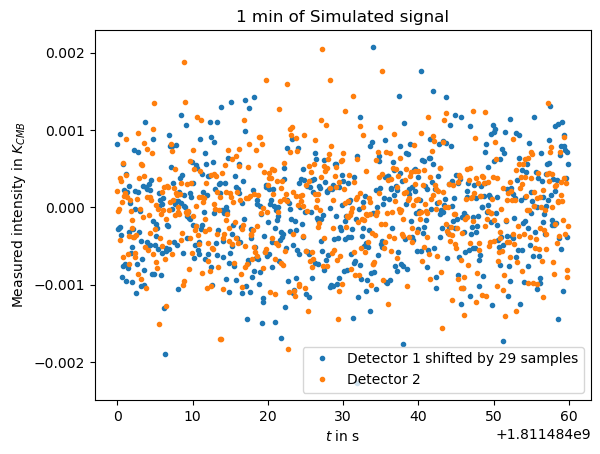

In [57]:
plt.plot(ob.shared["times"][0:600],ob.detdata["noise"][0][0:600],".", label = 'Detector 1 shifted by 29 samples') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.plot(ob.shared["times"][0:600],ob.detdata["noise"][1][0:600],".", label = 'Detector 2') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.xlabel('$t$ in s')
plt.ylabel('Measured intensity in $ K_{CMB}$')
plt.title('1 min of Simulated signal')
plt.legend(loc = 'best')
plt.show()

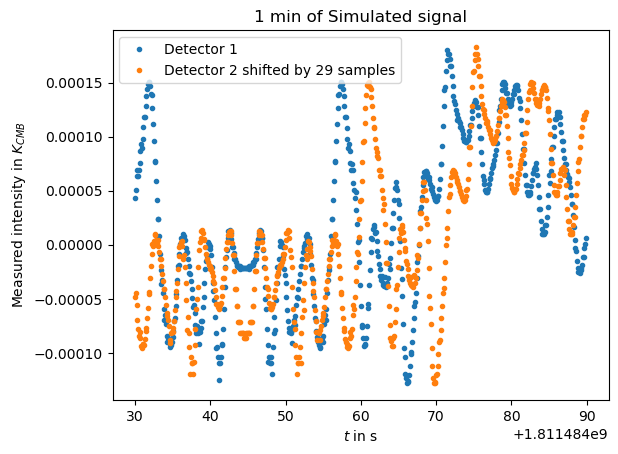

In [104]:
plt.plot(ob.shared["times"][300:900],ob.detdata["signal"][0][300:900],".", label = 'Detector 1') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.plot(ob.shared["times"][300:900],ob.detdata["signal"][1][300:900],".", label = 'Detector 2 shifted by 29 samples') ##Detdata has several data, signal is under "signal", detdata is a 2D array
plt.xlabel('$t$ in s')
plt.ylabel('Measured intensity in $ K_{CMB}$')
plt.title('1 min of Simulated signal')
plt.legend(loc = 'best')
plt.show()

In [105]:
quats_1 = ob.detdata['quats'][0]
quats_2 = ob.detdata['quats'][1]

In [106]:
#iso_ang1 = np.degrees(to_iso_angles(mult(xrot,quats_1)))
#iso_ang2 = np.degrees(to_iso_angles(mult(xrot,quats_2)))
#iso_ang1 = to_iso_angles(mult(xrot,quats_1))
#iso_ang2 = to_iso_angles(mult(xrot,quats_2))
iso_ang1 = to_iso_angles(quats_1)
iso_ang2 = to_iso_angles(quats_2)

In [107]:
iso_ang1

(array([2.45670639, 2.45670809, 2.45670978, ..., 2.45476228, 2.45476947,
        2.45477665]),
 array([-0.15552045, -0.15263052, -0.14974057, ...,  1.38759056,
         1.38472209,  1.38185359]),
 array([1.92190461, 1.92191635, 1.9219281 , ..., 1.9267978 , 1.92679494,
        1.92679204]))

In [108]:
#lambda1,phi1,psi1 = iso_ang1
#lambda2,phi2,psi2 = iso_ang2
#th1 = 90-lambda1
#th2 = 90-lambda2
th1,phi1,psi1 = iso_ang1
th2,phi2,psi2 = iso_ang2


In [109]:
print(phi1)

[-0.15552045 -0.15263052 -0.14974057 ...  1.38759056  1.38472209
  1.38185359]


In [110]:
pix_arr1 = hp.ang2pix(nside=NSIDE,theta= th1, phi = phi1, lonlat = False)

In [111]:
pix_arr2 = hp.ang2pix(nside=NSIDE,theta= th2, phi = phi2, lonlat = False)

In [112]:
time = ob.shared["times"]

In [113]:
N_time = time.shape[0]
print(N_time)

50400


In [114]:
npix = hp.nside2npix(NSIDE)

In [115]:
npix

3145728

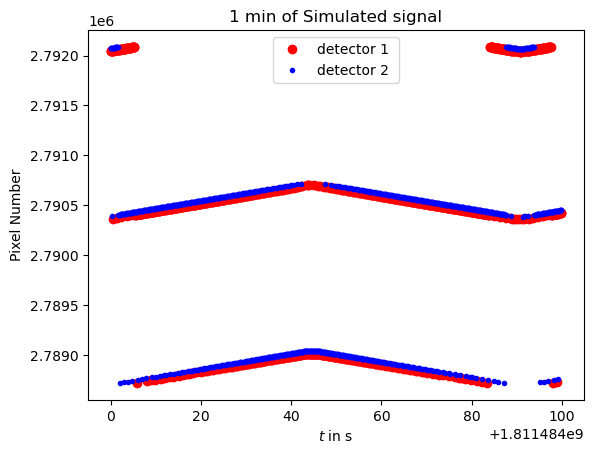

In [116]:
plt.plot(time[0:1000], pix_arr1[0:1000],'ro', label = 'detector 1 ')
plt.plot(time[0:1000], pix_arr2[0:1000],'b.', label = 'detector 2')
plt.xlabel('$t$ in s')
plt.ylabel('Pixel Number')
plt.title('1 min of Simulated signal')
plt.legend(loc = 'best')
plt.show()

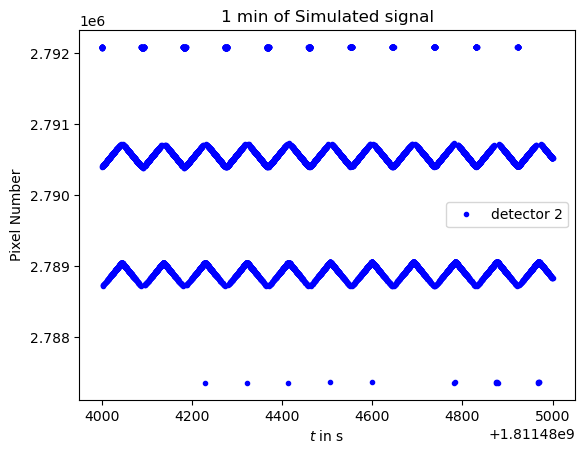

In [117]:
plt.plot(time[0:10000], pix_arr2[0:10000],'b.', label = 'detector 2')
plt.xlabel('$t$ in s')
plt.ylabel('Pixel Number')
plt.title('1 min of Simulated signal')
plt.legend(loc = 'best')
plt.show()

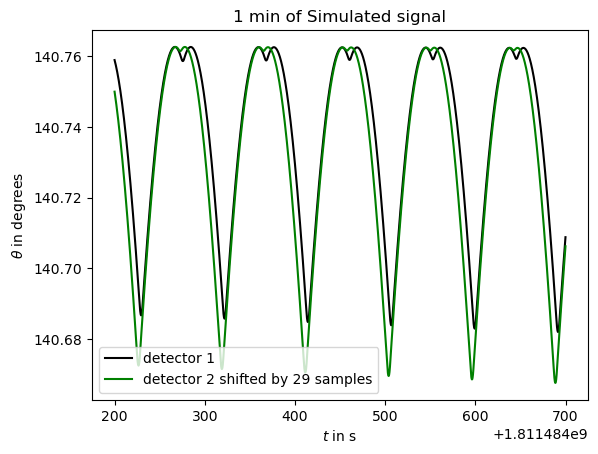

In [118]:
plt.plot(time[2000:7000], np.degrees(th1[2000:7000]),'k', label = 'detector 1')
plt.plot(time[2000:7000], np.degrees(th2[2029:7029]),'g', label = 'detector 2 shifted by 29 samples')

#plt.plot(time[2000:7000], np.degrees(th1[2029:7029]),'r', label = 'detector 1 shifted by 29 samples')
#plt.plot(time[2000:7000], np.degrees(th2[2000:7000]),'b', label = 'detector 2')


plt.xlabel('$t$ in s')
plt.ylabel(r'$\theta$ in degrees')
plt.title('1 min of Simulated signal')
plt.legend(loc = 'best')
plt.show()

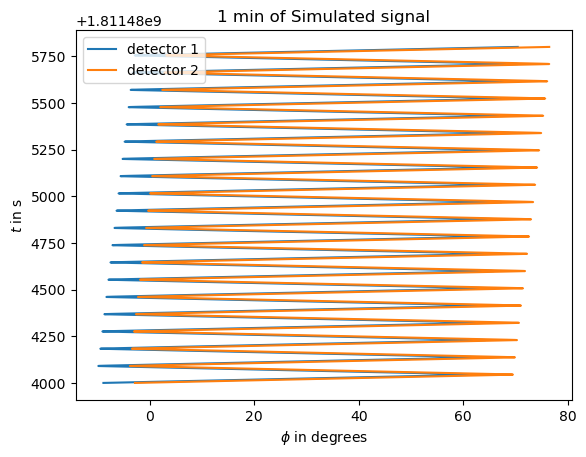

In [119]:
plt.plot(np.degrees(phi1[:18000]),time[:18000],  label = 'detector 1')
plt.plot(np.degrees(phi2[:18000]),time[:18000],  label = 'detector 2')
plt.ylabel('$t$ in s')
plt.xlabel(r'$\phi$ in degrees')
plt.title('1 min of Simulated signal')
plt.legend(loc = 'best')
plt.show()

In [120]:
data

<Data with 1 Observations:
<Observation
  name = 'POLE_DEEP-169-1'
  uid = '3569251122'  group has a single process (no MPI)
  telescope = <Telescope 'My_telescope': uid = 3533178314, site = <GroundSite 'SOUTH_POLE' : uid = 588178429, lon = -44.64999999999998 deg, lat = -89.991 deg, alt = 2842.9999999993684 m, weather = <SimWeather : 'south_pole', year = 2027, month = 4, hour = 6, site UID = 588178429, realization = 0, median = False)>, focalplane = <Focalplane: 252 detectors, sample_rate = 10.0 Hz, FOV = 29.77320077597548 deg, detectors = [029_000_SAT_f030_A .. 029_003_SAT_f030_A]>>
  session = <Session 'POLE_DEEP-169-1': uid = 527578977, start = 2027-05-28 06:00:00+00:00, end = 2027-05-28 07:23:59.900000+00:00>
  scan_el = 52.6 deg
  scan_min_az = 1.0861993598757675 rad
  scan_max_az = 2.366934565195013 rad
  scan_min_el = 0.9180431865490174 rad
  scan_max_el = 0.9180431865490174 rad
  noise_model = <AnalyticNoise model with 2 detectors>
  50400 total samples (50400 local)
  shared: 

In [121]:
np.where(ob.detdata['flags'][0]!=0)

(array([], dtype=int64),)

In [122]:
print(ob.intervals['throw'])

rec.array([(1.81148400e+09, 1.81148404e+09,     0,   445),
           (1.81148404e+09, 1.81148409e+09,   446,   907),
           (1.81148409e+09, 1.81148414e+09,   908,  1370),
           (1.81148414e+09, 1.81148418e+09,  1371,  1832),
           (1.81148418e+09, 1.81148423e+09,  1833,  2294),
           (1.81148423e+09, 1.81148428e+09,  2295,  2756),
           (1.81148428e+09, 1.81148432e+09,  2757,  3218),
           (1.81148432e+09, 1.81148437e+09,  3219,  3680),
           (1.81148437e+09, 1.81148441e+09,  3681,  4142),
           (1.81148441e+09, 1.81148446e+09,  4143,  4605),
           (1.81148446e+09, 1.81148451e+09,  4606,  5067),
           (1.81148451e+09, 1.81148455e+09,  5068,  5529),
           (1.81148455e+09, 1.81148460e+09,  5530,  5991),
           (1.81148460e+09, 1.81148465e+09,  5992,  6453),
           (1.81148465e+09, 1.81148469e+09,  6454,  6915),
           (1.81148469e+09, 1.81148474e+09,  6916,  7378),
           (1.81148474e+09, 1.81148478e+09,  7379,  7840

In [123]:
ob.intervals

<IntervalsManager 13 lists
  throw_leftright: 55 intervals
  throw_rightleft: 55 intervals
  throw: 110 intervals
  scan_leftright: 55 intervals
  turn_leftright: 55 intervals
  scan_rightleft: 55 intervals
  turn_rightleft: 54 intervals
  elnod: 0 intervals
  scanning: 110 intervals
  turnaround: 109 intervals
  sun_up: 0 intervals
  sun_close: 0 intervals>

In [124]:
ob.intervals['throw']

rec.array([(1.81148400e+09, 1.81148404e+09,     0,   445),
           (1.81148404e+09, 1.81148409e+09,   446,   907),
           (1.81148409e+09, 1.81148414e+09,   908,  1370),
           (1.81148414e+09, 1.81148418e+09,  1371,  1832),
           (1.81148418e+09, 1.81148423e+09,  1833,  2294),
           (1.81148423e+09, 1.81148428e+09,  2295,  2756),
           (1.81148428e+09, 1.81148432e+09,  2757,  3218),
           (1.81148432e+09, 1.81148437e+09,  3219,  3680),
           (1.81148437e+09, 1.81148441e+09,  3681,  4142),
           (1.81148441e+09, 1.81148446e+09,  4143,  4605),
           (1.81148446e+09, 1.81148451e+09,  4606,  5067),
           (1.81148451e+09, 1.81148455e+09,  5068,  5529),
           (1.81148455e+09, 1.81148460e+09,  5530,  5991),
           (1.81148460e+09, 1.81148465e+09,  5992,  6453),
           (1.81148465e+09, 1.81148469e+09,  6454,  6915),
           (1.81148469e+09, 1.81148474e+09,  6916,  7378),
           (1.81148474e+09, 1.81148478e+09,  7379,  7840

In [125]:
#throw_start = np.array([inter[2] for inter in ob.intervals['throw']])
#throw_end = np.array([inter[3] for inter in ob.intervals['throw']])
throw_lr_sample = np.array([(inter[2],inter[3]) for inter in ob.intervals['throw_leftright']])
throw_rl_sample = np.array([(inter[2],inter[3]) for inter in ob.intervals['throw_rightleft']])
scan_lr_sample = np.array([(inter[2],inter[3]) for inter in ob.intervals['scan_leftright']])
scan_rl_sample = np.array([(inter[2],inter[3]) for inter in ob.intervals['scan_rightleft']])

In [126]:
for interval in throw_lr_sample:
    print(interval[0], interval[1])

0 445
908 1370
1833 2294
2757 3218
3681 4142
4606 5067
5530 5991
6454 6915
7379 7840
8303 8764
9227 9688
10152 10613
11076 11537
12000 12461
12925 13386
13849 14310
14773 15234
15698 16159
16622 17083
17546 18007
18470 18932
19395 19856
20319 20780
21243 21705
22168 22629
23092 23553
24016 24478
24941 25402
25865 26326
26789 27251
27714 28175
28638 29099
29562 30024
30487 30948
31411 31872
32335 32796
33260 33721
34184 34645
35108 35569
36033 36494
36957 37418
37881 38342
38806 39267
39730 40191
40654 41115
41579 42040
42503 42964
43427 43888
44351 44813
45276 45737
46200 46661
47124 47586
48049 48510
48973 49434
49897 50359


In [127]:
RA_lr1 =[phi1[interval[0]:interval[1]] for interval in throw_lr_sample]
RA_rl1 =[phi1[interval[0]:interval[1]] for interval in throw_rl_sample]

RA_lr2 = [phi2[interval[0]:interval[1]] for interval in throw_lr_sample]
RA_rl2 = [phi2[interval[0]:interval[1]] for interval in throw_rl_sample]

In [137]:
RA_lr1scan =[phi1[interval[0]:interval[1]] for interval in scan_lr_sample]
RA_rl1scan =[phi1[interval[0]:interval[1]] for interval in scan_rl_sample]

RA_lr2scan = [phi2[interval[0]:interval[1]] for interval in scan_lr_sample]
RA_rl2scan= [phi2[interval[0]:interval[1]] for interval in scan_rl_sample]

In [129]:
signal_lr1 = [ob.detdata["signal"][0,interval[0]:interval[1]] for interval in throw_lr_sample]
signal_lr2 = [ob.detdata["signal"][1,interval[0]:interval[1]] for interval in throw_lr_sample]

signal_rl1 = [ob.detdata["signal"][0,interval[0]:interval[1]] for interval in throw_rl_sample]
signal_rl2 = [ob.detdata["signal"][1,interval[0]:interval[1]] for interval in throw_rl_sample]

In [138]:
signal_lr1scan = [ob.detdata["signal"][0,interval[0]:interval[1]] for interval in scan_lr_sample]
signal_lr2scan = [ob.detdata["signal"][1,interval[0]:interval[1]] for interval in scan_lr_sample]

signal_rl1scan = [ob.detdata["signal"][0,interval[0]:interval[1]] for interval in scan_rl_sample]
signal_rl2scan = [ob.detdata["signal"][1,interval[0]:interval[1]] for interval in scan_rl_sample]

In [132]:
total_lr1 = [ob.detdata["total"][0,interval[0]:interval[1]] for interval in throw_lr_sample]
total_lr2 = [ob.detdata["total"][1,interval[0]:interval[1]] for interval in throw_lr_sample]

total_rl1 = [ob.detdata["total"][0,interval[0]:interval[1]] for interval in throw_rl_sample]
total_rl2 = [ob.detdata["total"][1,interval[0]:interval[1]] for interval in throw_rl_sample]

In [141]:
total_lr1scan = [ob.detdata["total"][0,interval[0]:interval[1]] for interval in scan_lr_sample]
total_lr2scan = [ob.detdata["total"][1,interval[0]:interval[1]] for interval in scan_lr_sample]

total_rl1scan = [ob.detdata["total"][0,interval[0]:interval[1]] for interval in scan_rl_sample]
total_rl2scan = [ob.detdata["total"][1,interval[0]:interval[1]] for interval in scan_rl_sample]

Text(0.5, 1.0, 'First left-right throw')

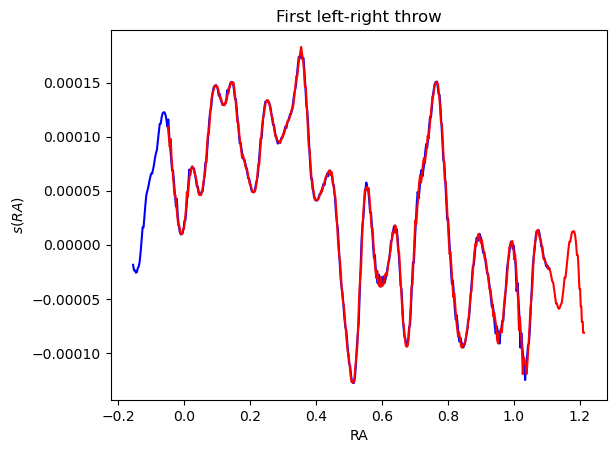

In [134]:

plt.plot(RA_lr1[0],signal_lr1[0],'b-')
plt.plot(RA_lr2[0],signal_lr2[0],'r-')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.title('First left-right throw')
#plt.plot(RA_lr1[54],signal_lr1[54],'b')
#plt.plot(RA_lr2[54],signal_lr2[54],'r')

In [146]:
print(RA_lr1scan[0].shape)
print(RA_lr2scan[0].shape)

(429,)
(429,)


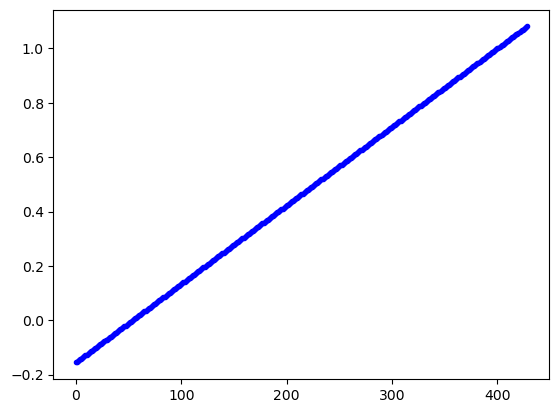

In [153]:
plt.plot(np.arange(0,RA_lr1scan[0].shape[0]),RA_lr1scan[0],'b.')

Text(0.5, 1.0, 'First left-right scan')

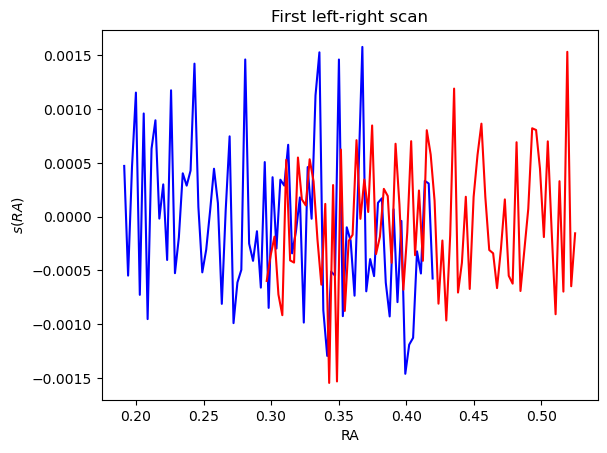

In [150]:

plt.plot(RA_lr1scan[0][120:200],total_lr1scan[0][120:200],'b-')
plt.plot(RA_lr2scan[0][120:200],total_lr2scan[0][120:200],'r-')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.title('First left-right scan')
#plt.plot(RA_lr1[54],signal_lr1[54],'b')
#plt.plot(RA_lr2[54],signal_lr2[54],'r')

Text(0.5, 1.0, '20th left-right throw')

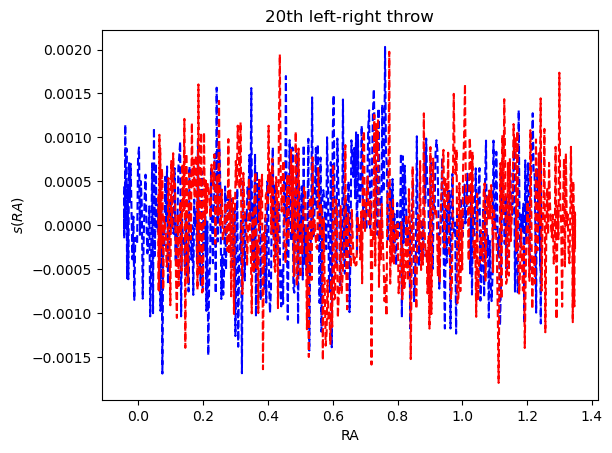

In [162]:

plt.plot(RA_lr1[20],total_lr1[20],'b--')
plt.plot(RA_lr2[20],total_lr2[20],'r--')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.title('20th left-right throw')
#plt.plot(RA_lr1[54],signal_lr1[54],'b')
#plt.plot(RA_lr2[54],signal_lr2[54],'r')

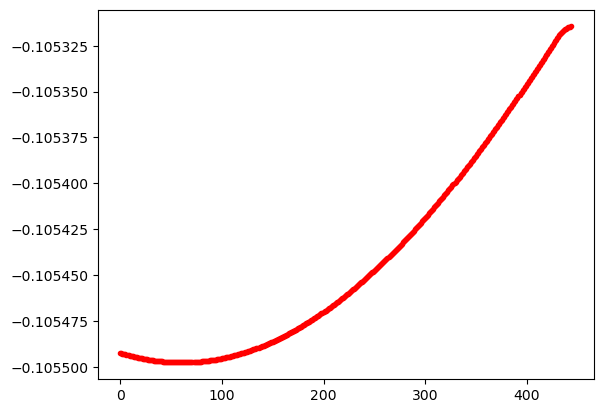

In [160]:
#plt.plot(np.arange(0,RA_lr1[0].shape[0]),RA_lr1[0],'b')
#plt.plot(np.arange(0,RA_lr1[0].shape[0]),RA_lr2[0],'r')
plt.plot(np.arange(0,RA_lr1[0].shape[0]),RA_lr1[0]-RA_lr2[0],'r.')


In [163]:
def combine_arrays(x1, y1, x2, y2):
    combined_x = np.union1d(x1, x2)
    combined_y = np.zeros_like(combined_x, dtype=float)
    
    for i, x in enumerate(combined_x):
        if x in x1 and x in x2:
            combined_y[i] = (y1[np.where(x1 == x)] + y2[np.where(x2 == x)]) / 2
        elif x in x1:
            combined_y[i] = y1[np.where(x1 == x)]
        else:
            combined_y[i] = y2[np.where(x2 == x)]
    
    return combined_x, combined_y

In [164]:
# Example usage:
x1 = np.array([1, 2, 3, 4])
y1 = np.array([10, 20, 30, 40])
x2 = np.array([3, 4, 5, 6])
y2 = np.array([300, 400, 500, 600])

In [166]:
np.union1d(x1,x2)

array([1, 2, 3, 4, 5, 6])

In [165]:
combined_x, combined_y = combine_arrays(x1, y1, x2, y2)

/tmp/ipykernel_208003/3925583138.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  combined_y[i] = y1[np.where(x1 == x)]
/tmp/ipykernel_208003/3925583138.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  combined_y[i] = (y1[np.where(x1 == x)] + y2[np.where(x2 == x)]) / 2
/tmp/ipykernel_208003/3925583138.py:11: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  combined_y[i] = y2[np.where(x2 == x)]


Text(0.5, 1.0, 'First right-left throw')

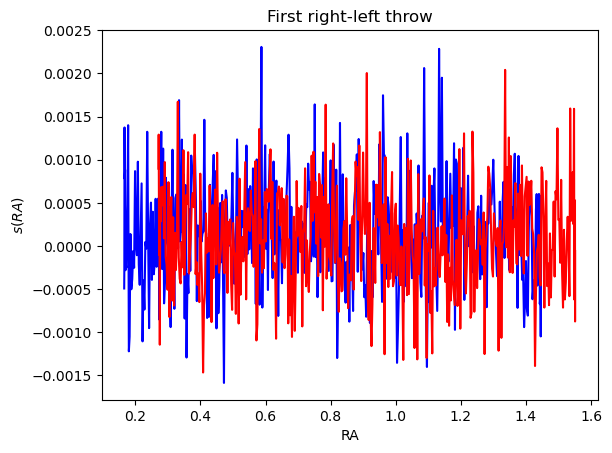

In [136]:
#plt.plot(RA_rl1[0],signal_rl1[0],'b--')
#plt.plot(RA_rl2[0],signal_rl2[0],'r--')
plt.plot(RA_rl1[50],total_rl1[50],'b')
plt.plot(RA_rl2[50],total_rl2[50],'r')
plt.xlabel('RA')
plt.ylabel(r'$s(RA)$')
plt.title('First right-left throw')

## Create a pointing matrix

Compute $P^T P$. It is block diagonal of shape $3n_{pix}^2$, with each block having the form $\begin{pmatrix}N & \sum c &\sum s \\ \sum c &\sum c^2 &\sum cs \\ \sum s &\sum cs &\sum s^2\end{pmatrix}$

In [87]:
pointing_arr = np.zeros((2*N_time,3*npix),dtype = complex)

In [88]:
pix_arr1.shape

(50400,)

In [89]:
for t in range(N_time):
    for pol in range(3):
        pointing_arr[t, pol*pix_arr1[t]] = 1
        pointing_arr[t, pol*pix_arr1[t]] = np.cos(2*psi1[t])
        pointing_arr[t, pol*pix_arr1[t]] = np.sin(2*psi1[t])
        pointing_arr[2*t, pol*pix_arr2[t]] = 1
        pointing_arr[2*t, pol*pix_arr2[t]] = np.cos(2*psi2[t])
        pointing_arr[2*t, pol*pix_arr2[t]] = np.sin(2*psi2[t])

In [90]:
pointing_arr.shape

(100800, 9437184)

In [91]:
3*npix

9437184

In [92]:
print(pointing_arr)

[[-0.76154032+0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [-0.64592935+0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [-0.64594729+0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 ...
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [-0.76739286+0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]
 [ 0.        +0.j  0.        +0.j  0.        +0.j ...  0.        +0.j
   0.        +0.j  0.        +0.j]]


# Hit maps

/global/homes/j/jtanglbl/.conda/envs/toastdev/lib/python3.9/site-packages/healpy/projector.py:201: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


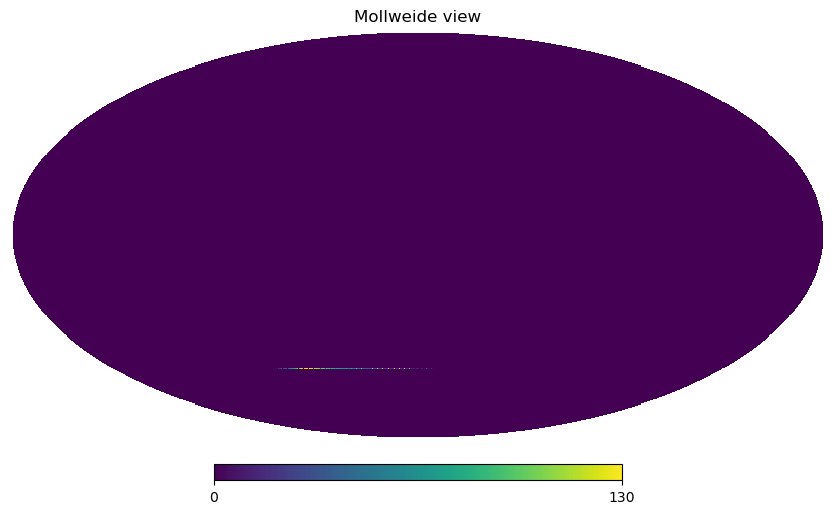

In [93]:
hitmap1 = np.zeros(npix,dtype = complex)

for pix in pix_arr1:
    hitmap1[pix]+=1
#hitmap1[hitmap1==0] = hp.UNSEEN
hp.mollview(hitmap1)

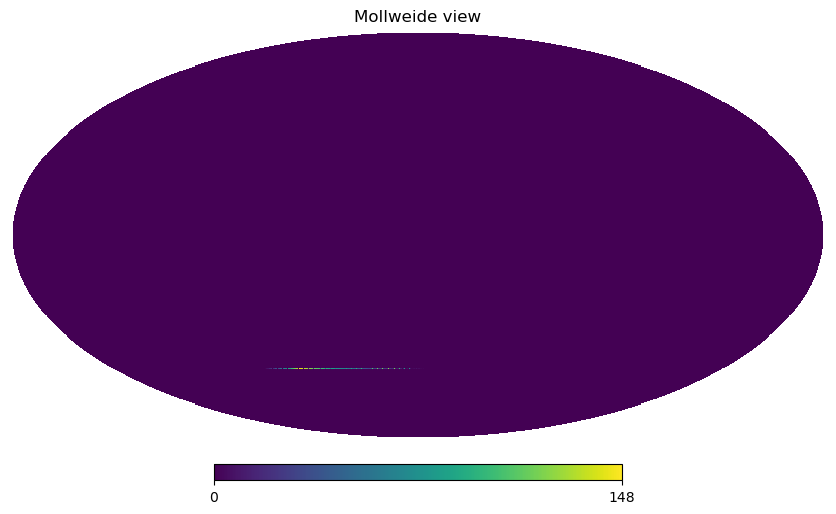

In [94]:
hitmap2 = np.zeros(npix,dtype = complex)

for pix in pix_arr2:
    hitmap2[pix]+=1
#hitmap2[hitmap2==0] = hp.UNSEEN

hp.mollview(hitmap2)

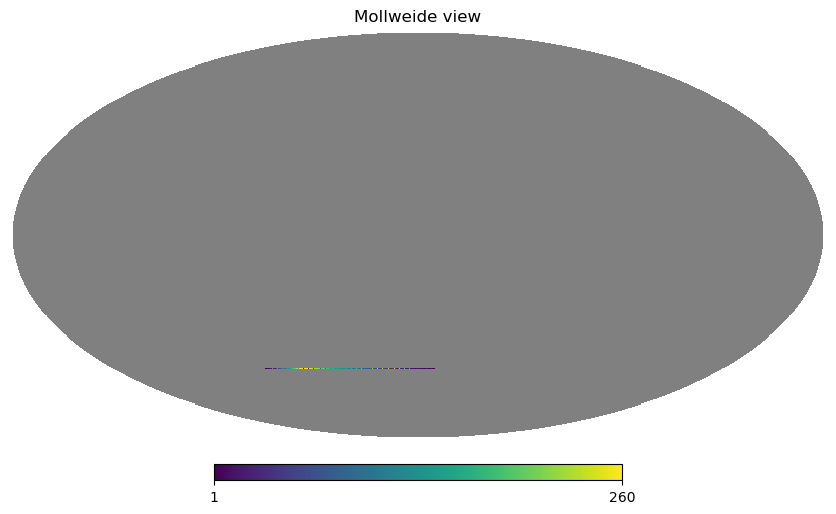

In [95]:
hitmap_tot = hitmap1+hitmap2
hitmap_tot[hitmap_tot==0] = hp.UNSEEN
hp.mollview(hitmap_tot)

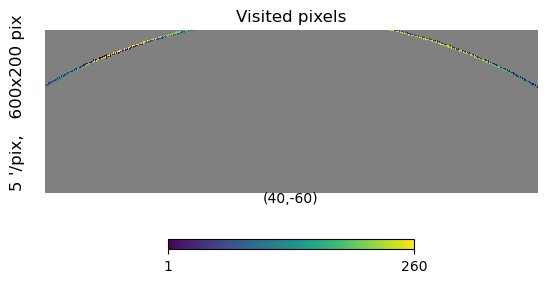

In [96]:
hp.gnomview(hitmap_tot,rot = (40,-60),xsize = 600,ysize=200,reso = 5,   title = 'Visited pixels')

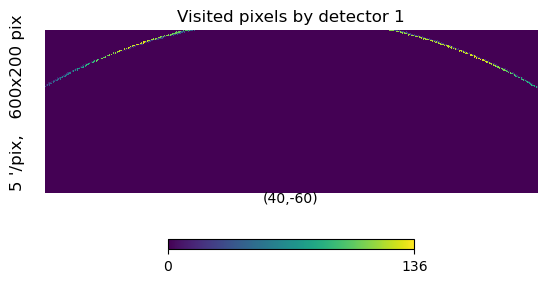

In [97]:
hp.gnomview(hitmap1,rot = (40,-60),xsize = 600,ysize=200,reso = 5,   title = 'Visited pixels by detector 1')

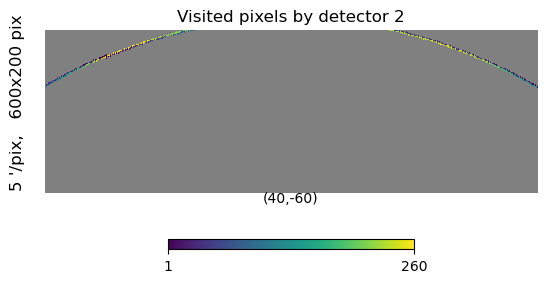

In [98]:
hp.gnomview(hitmap_tot,rot = (40,-60),xsize = 600,ysize=200,reso = 5,   title = 'Visited pixels by detector 2')

In [99]:
t_arr = np.arange(0,1000)

In [100]:
100%7

2

In [101]:
def triangle(N, t1,t2,slope):
    resul = np.zeros(N)
    for i in range(N-1):
        q = i//t2
        r = i%t2
        if r<t1:
            resul[i+1] = resul[i]+slope
        else : 
            resul[i+1] = resul[i]-slope
    return(resul)

In [102]:
res_arr = triangle(1000,35,60,3)

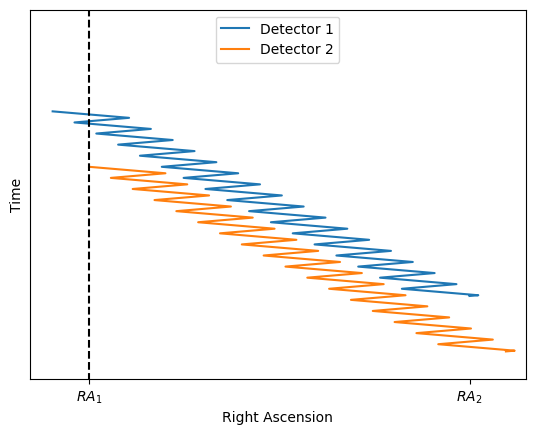

In [103]:
plt.plot(res_arr,-t_arr-550,label = 'Detector 1')
plt.plot(res_arr+50,-t_arr-850,label = 'Detector 2')
plt.vlines(x=50,ymin = -3000, ymax = 1000,colors='k', linestyles='--')
plt.legend(loc = 'upper center')
plt.xlabel('Right Ascension')
plt.ylabel('Time')
plt.xlim(right = 650)
plt.ylim(top = 0,bottom = -2000)
plt.yticks([])
plt.xticks([50,res_arr[-1]],['$RA_1$','$RA_2$'])
plt.savefig('schema_principe.pdf')